<a href="https://colab.research.google.com/github/pratiksrm99/Abstractive_Text_Summerization/blob/main/Abstractive_TS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install datasets
!pip install pywsd
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 KB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 22.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 16.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.9/26.9 MB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.6/31.6 MB 33.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for wn: filename=wn-0.0.23-py3-none-any.whl size=31792926 sha256=d05bbaac4d7a6b5da06b73a2e549bdf3e6787d348832e18e8d52b1070703b0ab
  Stored in directory: /root/.cache/pip/wheels/6

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [2]:
from datasets import load_dataset
from nltk.corpus import wordnet as wn
from nltk.tokenize import word_tokenize
from nltk import FreqDist
from pywsd.lesk import adapted_lesk, simple_lesk, cosine_lesk
import pandas as pd
import numpy as np
import spacy
import re
from gensim.models import Word2Vec

Warming up PyWSD (takes ~10 secs)... took 13.004674434661865 secs.


In [3]:
dataset = load_dataset('gigaword')

Generating train split:   0%|          | 0/3803957 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/189651 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1951 [00:00<?, ? examples/s]

Dataset gigaword downloaded and prepared to /root/.cache/huggingface/datasets/gigaword/default/1.2.0/ea83a8b819190acac5f2dae011fad51dccf269a0604ec5dd24795b64efb424b6. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [4]:
df = pd.DataFrame(columns= ["Document", "Summary"])
df["Document"] = dataset.get("train")["document"]
df["Summary"] = dataset.get("train")["summary"]
df = df.loc[0:9999,:]
df["Document"] = df["Document"].apply(lambda x: re.sub('[^A-Za-z0-9]+', ' ', x))
df["Document"] = df["Document"].apply(lambda x: re.sub(r'(?:^| )\w(?:$| )', ' ', x).strip())
df["Summary"] = df["Summary"].apply(lambda x: re.sub('[^A-Za-z0-9]+', ' ', x))
df["Summary"] = df["Summary"].apply(lambda x: re.sub(r'(?:^| )\w(?:$| )', ' ', x).strip())
df

,Document,Summary
0,australia current account deficit shrunk by re...,australian current account deficit narrows sha...
1,at least two people were killed in suspected b...,at least two dead in southern philippines blast
2,australian shares closed down percent monday f...,australian stocks close down percent
3,south korea nuclear envoy kim sook urged north...,envoy urges north korea to restart nuclear dis...
4,south korea on monday announced sweeping tax r...,skorea announces tax cuts to stimulate economy
...,...,...
9995,sri lanka is reviewing an agreement to allow t...,sri lanka to review agreement for setting up v...
9996,the UNK liner qe finally left the port of new ...,qe leaves new york
9997,zimbabwe only independent daily newspaper the ...,zimbabwe only independent daily winds up
9998,cambodia foreign minister saturday ordered an ...,cambodian government investigates missing germ...


In [5]:
# df["Split_text"] = df["Document"].apply(str.split)
# df["Article_length"] = df["Split_text"].apply(len)

In [6]:
df.head(20)

,Document,Summary
0,australia current account deficit shrunk by re...,australian current account deficit narrows sha...
1,at least two people were killed in suspected b...,at least two dead in southern philippines blast
2,australian shares closed down percent monday f...,australian stocks close down percent
3,south korea nuclear envoy kim sook urged north...,envoy urges north korea to restart nuclear dis...
4,south korea on monday announced sweeping tax r...,skorea announces tax cuts to stimulate economy
5,taiwan share prices closed down percent monday...,taiwan shares close down percent
6,australian shares closed down percent monday f...,australian stocks close down percent
7,spanish property group colonial struggling und...,spain colonial posts billion euro loss
8,libyan leader moamer kadhafi monday promised w...,kadhafi promises wide political economic reforms
9,the united nations humanitarian chief john hol...,un top aid official arrives in drought hit eth...


# **Implementation of Algorithm 1 from the paper**

Algorithm 1 Level-driven text generalization (LG)

Require: text, wsdText, F, T, θd
, θf

1: genText ← text

2: for all token ∈ text do

3: ftoken ← Frequency of token from F

4: if ftoken ≤ θf
then

5: c ← WSD of token form wsdText

6: Pc ← Path of hypernyms of c from T

7: dc ← taxonomy depth of concept c

8: fc ← Frequency of c from F

9: while fc < θf and dc > θd do

10: c ← hypernym of c from Ptoken

11: dc ← taxonomy depth of c

12: fc ← Frequency of c from F

13: end while

14: if (word of c) 6= token then

15: genText ← generalize token of genText to c

16: F ← (F \ {(token, ftoken)}) ∪ {(token, ftoken − 1)}

17: F ← (F \ {(c, fc
)}) ∪ {(c, fc + 1)}

18: end if

19: end if

20: end for

21: return genText

In [7]:
sent = "he is sitting on the bank of the river watching a speedboat in japan."
nlp = spacy.load("en_core_web_sm")

def one_func(x):
  try:
    if x.pos_=="NOUN":
      return adapted_lesk(sent,x.text).name()
    else:
      return x.text
  except:
    return x.text

def wsd_text(sent):
  doc = nlp(sent)
  test_df = pd.DataFrame(doc,columns=["text"])
  test_df["wsd"] = test_df["text"].apply(one_func)
  return " ".join(test_df["wsd"])

In [8]:
df["WSD Text"] = df["Document"].apply(wsd_text)

In [9]:
df.head()

,Document,Summary,WSD Text
0,australia current account deficit shrunk by re...,australian current account deficit narrows sha...,australia current score.n.05 deficit.n.04 shru...
1,at least two people were killed in suspected b...,at least two dead in southern philippines blast,at least two people.v.02 were killed in suspec...
2,australian shares closed down percent monday f...,australian stocks close down percent,australian share.v.05 closed down percentage.n...
3,south korea nuclear envoy kim sook urged north...,envoy urges north korea to restart nuclear dis...,south korea nuclear envoy.n.03 kim sook urged ...
4,south korea on monday announced sweeping tax r...,skorea announces tax cuts to stimulate economy,south korea on monday announced sweeping tax.v...


In [10]:
a = df['WSD Text'].str.cat(sep=' ')
test_list = re.findall("[\w]+\..{1}\..{2}",a)
word_dist = FreqDist(test_list)
word_dist

FreqDist({'dollar.n.04': 1059, 'percentage.n.01': 945, 'politics.n.02': 883, 'official.s.05': 881, 'year.n.03': 834, 'state.n.04': 793, 'share.v.05': 775, 'marketplace.n.02': 771, 'sidereal_day.n.01': 627, 'agency.n.01': 626, ...})

In [11]:
thetha_d = 5
thetha_f = 100

def to_generalize(sent,thetha_d,thetha_f,word_dist):

  try:
    word_lst = [word for word in re.findall('[\w]+\..{1}\..{2}', sent) \
                if (word_dist[word] < thetha_f) and (len(wn.synset(word).hypernym_paths()[0])-1 > thetha_d)]

    for word in word_lst:
      while word_dist[word] < thetha_f and (len(wn.synset(word).hypernym_paths()[0])-1 > thetha_d):
        try:
          sent = sent.replace(word, str(wn.synset(word).hypernyms()[0].name()))
        except:
          sent = sent.replace(i, str(wn.synset(word).attributes()[0].name()))
        finally:
          word = wn.synset(word).hypernyms()[0].name()
  except:
    return "Error while generalizing"

  return sent

In [12]:
df["Generalized Text"] = df["WSD Text"].apply(lambda x: to_generalize(x,thetha_d,thetha_f,word_dist))
# xyz=23
# print(df["WSD Text"][xyz],"\n",df["Document"][xyz])

In [13]:
df[["Document","WSD Text", "Generalized Text"]]

,Document,WSD Text,Generalized Text
0,australia current account deficit shrunk by re...,australia current score.n.05 deficit.n.04 shru...,australia current reason.n.01 deficit.n.04 shr...
1,at least two people were killed in suspected b...,at least two people.v.02 were killed in suspec...,at least two people.v.02 were killed in suspec...
2,australian shares closed down percent monday f...,australian share.v.05 closed down percentage.n...,australian share.v.05 closed down percentage.n...
3,south korea nuclear envoy kim sook urged north...,south korea nuclear envoy.n.03 kim sook urged ...,south korea nuclear matter.n.06 kim sook urged...
4,south korea on monday announced sweeping tax r...,south korea on monday announced sweeping tax.v...,south korea on monday announced sweeping tax.v...
...,...,...,...
9995,sri lanka is reviewing an agreement to allow t...,sri lanka is reviewing an agreement.n.06 to al...,Error while generalizing
9996,the UNK liner qe finally left the port of new ...,the UNK lining.n.01 qe finally left the port.v...,the UNK covering.n.02 qe finally left the port...
9997,zimbabwe only independent daily newspaper the ...,zimbabwe only independent daily newspaper.n.04...,zimbabwe only independent daily paper.n.01 the...
9998,cambodia foreign minister saturday ordered an ...,cambodia foreign minister saturday ordered an ...,cambodia foreign minister saturday ordered an ...


In [19]:
test_gen=to_generalize(wsd_text(sent),thetha_d,thetha_f,word_dist)
print(sent,"\n",test_gen)
wn.synset('instrumentality.n.03').definition()
new_df = df[df["Generalized Text"]!="Error while generalizing"]
new_df = new_df[["Generalized Text", "Summary"]]
new_df["Summary"] = 'sostok _START_ '+new_df['Summary']+' _END_ eostok'
new_df

he is sitting on the bank of the river watching a speedboat in japan. 
 he is sitting on the bank.n.01 of the river.n.01 watching a instrumentality.n.03 in japan .


,Generalized Text,Summary
0,australia current reason.n.01 deficit.n.04 shr...,sostok _START_ australian current account defi...
1,at least two people.v.02 were killed in suspec...,sostok _START_ at least two dead in southern p...
2,australian share.v.05 closed down percentage.n...,sostok _START_ australian stocks close down pe...
3,south korea nuclear matter.n.06 kim sook urged...,sostok _START_ envoy urges north korea to rest...
4,south korea on monday announced sweeping tax.v...,sostok _START_ skorea announces tax cuts to st...
...,...,...
9993,twelve.s.01 of bahraini activity.n.01 student....,sostok _START_ bahraini students in iran prote...
9996,the UNK covering.n.02 qe finally left the port...,sostok _START_ qe leaves new york _END_ eostok
9997,zimbabwe only independent daily paper.n.01 the...,sostok _START_ zimbabwe only independent daily...
9998,cambodia foreign minister saturday ordered an ...,sostok _START_ cambodian government investigat...


In [20]:
new_df["Gen_text_list"] = new_df["Generalized Text"].apply(str.split)
new_df["Summary_list"] = new_df["Summary"].apply(str.split)
i=4
gen_sentences = new_df["Gen_text_list"].to_list()
gen_summary = new_df["Summary_list"].to_list()
gen_text = gen_sentences + gen_summary
new_df['Text_len'] = new_df["Gen_text_list"].apply(len)
new_df['Summary_len'] = new_df["Summary_list"].apply(len)
# new_df['n_summary'] = new_df['Summary'].apply(lambda x : 'sostok '+ x + ' eostok')

In [21]:
j=0
print(gen_sentences[j],"\n",gen_summary[j])
new_df.head()

['australia', 'current', 'reason.n.01', 'deficit.n.04', 'shrunk', 'by', 'record.v.04', 'billion', 'dollar.n.04', 'lrb', 'billion', 'us', 'rrb', 'in', 'the', 'june', 'surface.n.01', 'due', 'to', 'soaring', 'commodity.n.01', 'price.v.02', 'visualize.v.01', 'released', 'monday', 'showed'] 
 ['sostok', '_START_', 'australian', 'current', 'account', 'deficit', 'narrows', 'sharply', '_END_', 'eostok']


,Generalized Text,Summary,Gen_text_list,Summary_list,Text_len,Summary_len
0,australia current reason.n.01 deficit.n.04 shr...,sostok _START_ australian current account defi...,"[australia, current, reason.n.01, deficit.n.04...","[sostok, _START_, australian, current, account...",26,10
1,at least two people.v.02 were killed in suspec...,sostok _START_ at least two dead in southern p...,"[at, least, two, people.v.02, were, killed, in...","[sostok, _START_, at, least, two, dead, in, so...",24,12
2,australian share.v.05 closed down percentage.n...,sostok _START_ australian stocks close down pe...,"[australian, share.v.05, closed, down, percent...","[sostok, _START_, australian, stocks, close, d...",19,9
3,south korea nuclear matter.n.06 kim sook urged...,sostok _START_ envoy urges north korea to rest...,"[south, korea, nuclear, matter.n.06, kim, sook...","[sostok, _START_, envoy, urges, north, korea, ...",25,12
4,south korea on monday announced sweeping tax.v...,sostok _START_ skorea announces tax cuts to st...,"[south, korea, on, monday, announced, sweeping...","[sostok, _START_, skorea, announces, tax, cuts...",25,11


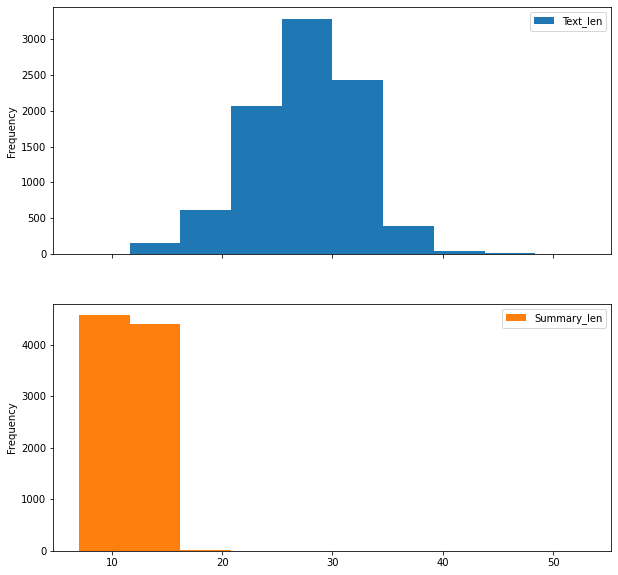

In [22]:
new_df.plot(kind='hist',subplots=True, figsize=(10,10))

max_text_len= new_df['Text_len'].max()
max_summary_len= new_df['Summary_len'].max()

In [ ]:
w2v = Word2Vec(gen_text, min_count=1, size = 300, window=5,alpha=0.025, min_alpha=0.001, iter=10)
# w2v_summary = Word2Vec(gen_summary, min_count=1, size = 300, window=5,alpha=0.025, min_alpha=0.001, iter=10)

In [23]:
from keras.layers import Input,Embedding, LSTM, Dense, Concatenate, Activation, Bidirectional, Layer, TimeDistributed
from keras.models import Model, Sequential, load_model
import keras.backend as K
from keras.callbacks import EarlyStopping

In [24]:
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences

In [25]:
x_tr,x_val,y_tr,y_val = train_test_split(np.array(new_df["Generalized Text"]),np.array(new_df["Summary"]),test_size=0.1, random_state=0,shuffle=True)

In [26]:
(x_tr[0],"\n",y_tr[0])

('hong kong share.v.05 price.v.02 closed down percentage.n.01 on tuesday after the flop.n.04 of us investment bank lehman brothers trader.n.01 said',
 '\n',
 'sostok _START_ hong kong shares close down percent _END_ eostok')

In [27]:
x_tokenizer = Tokenizer(filters='!"#$%&()*+,-/:;<=>?@[\\]^_`{|}~\t\n')
x_tokenizer.fit_on_texts(x_tr)

x_tr_seq= x_tokenizer.texts_to_sequences(x_tr)
x_val_seq= x_tokenizer.texts_to_sequences(x_val)

x_tr=pad_sequences(x_tr_seq, maxlen=max_text_len, padding='post')
x_val=pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

x_voc = len(x_tokenizer.word_index) + 1


In [28]:
y_tokenizer = Tokenizer(filters='!"#$%&()*+,-/:;<=>?@[\\]^_`{|}~\t\n')
y_tokenizer.fit_on_texts(y_tr)

y_tr_seq= y_tokenizer.texts_to_sequences(y_tr)
y_val_seq= y_tokenizer.texts_to_sequences(y_val)

y_tr=pad_sequences(y_tr_seq, maxlen=max_summary_len ,padding='post')
y_val=pad_sequences(y_val_seq, maxlen=max_summary_len ,padding='post')

y_voc = len(y_tokenizer.word_index) + 1


In [29]:
print(y_tokenizer.word_index)

{'end': 1, 'start': 2, 'sostok': 3, 'eostok': 4, 'to': 5, 'in': 6, 'on': 7, 'for': 8, 'of': 9, 'us': 10, 'percent': 11, 'shares': 12, 'as': 13, 'new': 14, 'unk': 15, 'says': 16, 'after': 17, 'over': 18, 'at': 19, 'with': 20, 'china': 21, 'up': 22, 'close': 23, 'down': 24, 'talks': 25, 'stocks': 26, 'un': 27, 'bank': 28, 'eu': 29, 'dollar': 30, 'crisis': 31, 'bailout': 32, 'financial': 33, 'the': 34, 'chinese': 35, 'and': 36, 'against': 37, 'pm': 38, 'from': 39, 'killed': 40, 'oil': 41, 'russia': 42, 'world': 43, 'deal': 44, 'two': 45, 'rescue': 46, 'president': 47, 'higher': 48, 'israel': 49, 'prices': 50, 'lower': 51, 'russian': 52, 'french': 53, 'british': 54, 'plan': 55, 'kong': 56, 'government': 57, 'hong': 58, 'south': 59, 'dollars': 60, 'peace': 61, 'indian': 62, 'police': 63, 'bush': 64, 'out': 65, 'calls': 66, 'minister': 67, 'amid': 68, 'three': 69, 'india': 70, 'pakistan': 71, 'obama': 72, 'first': 73, 'trade': 74, 'markets': 75, 'mccain': 76, 'off': 77, 'billion': 78, 'chief

In [48]:
latent_dim = 300
embedding_dim=200

# Encoder
encoder_inputs = Input(shape=(max_text_len,))

#embedding layer
enc_emb =  Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = Bidirectional(LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4))
encoder_output1, state_h1, state_c1, *_= encoder_lstm1(enc_emb)

# #encoder lstm 2
# encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
# encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# #encoder lstm 3
# encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
# encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h1, state_c1])

#dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, 53)]         0           []                               
                                                                                                  
 input_15 (InputLayer)          [(None, None)]       0           []                               
                                                                                                  
 embedding_10 (Embedding)       (None, 53, 200)      2292200     ['input_14[0][0]']               
                                                                                                  
 embedding_11 (Embedding)       (None, None, 200)    1508600     ['input_15[0][0]']               
                                                                                            

In [49]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)

In [ ]:
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=10,callbacks=[es],batch_size=64, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

Epoch 1/10


127/127 [==============================] - 82s 589ms/step - loss: 3.0087 - val_loss: 2.0586
Epoch 2/10
127/127 [==============================] - 62s 484ms/step - loss: 2.1071 - val_loss: 1.9150
Epoch 3/10
 96/127 [=====================>........] - ETA: 14s - loss: 2.0072

In [42]:
model.save('TS_LSTM.model')

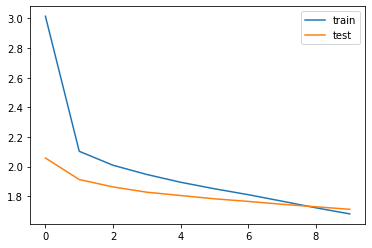

In [36]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [37]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

In [38]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_outputs2) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [39]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [40]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [41]:
for i in range(0,10):
    print("Review:",seq2text(x_tr[i]))
    print("Original summary:",seq2summary(y_tr[i]))
    print("Predicted summary:",decode_sequence(x_tr[i].reshape(1,max_text_len)))
    print("\n")

Review: hong kong share.v.05 price.v.02 closed down percentage.n.01 on tuesday after the flop.n.04 of us investment bank lehman brothers trader.n.01 said 
Original summary: start hong kong shares close down percent end 
1/1 [==============================] - 0s 22ms/step
Predicted summary:  start us bank to send unk to be aid to be dispute end


Review: the united states on wednesday welcomed the movement.n.03 of long delayed provincial election.n.04 police.n.01 by the iraqi parliament.n.01 saying it showed the state.n.04 novice.n.02 belief.n.01 was making progress.v.01 
Original summary: start us welcomes iraq local election law end 
1/1 [==============================] - 0s 22ms/step
Predicted summary:  start us bank to send unk to be aid to be aid end


Review: ghana ruling new patriotic party.v.01 lrb npp rrb tuesday pledged to manage the state.n.04 future vegetable oil.n.01 sum.n.01 well if it is re elected in december poll.v.04 
Original summary: start ghana ruling npp vows to ma

In [ ]:
for x in y_tokenizer.index_word:
  if reverse_target_word_index[x]=='sostok' or reverse_target_word_index[x]=='eostok':
    print(x)

w2v_summary.wv.vocab

1
2


{'sostok': <gensim.models.keyedvectors.Vocab at 0x7f4e4f0a7460>,
 'australian': <gensim.models.keyedvectors.Vocab at 0x7f4e4f0a7520>,
 'current': <gensim.models.keyedvectors.Vocab at 0x7f4e4f8edee0>,
 'account': <gensim.models.keyedvectors.Vocab at 0x7f4e4f8f48b0>,
 'deficit': <gensim.models.keyedvectors.Vocab at 0x7f4e4f8f4850>,
 'narrows': <gensim.models.keyedvectors.Vocab at 0x7f4e4f8f4760>,
 'sharply': <gensim.models.keyedvectors.Vocab at 0x7f4e4f8f4640>,
 'eostok': <gensim.models.keyedvectors.Vocab at 0x7f4e4f8f4700>,
 'at': <gensim.models.keyedvectors.Vocab at 0x7f4e4f8f4a00>,
 'least': <gensim.models.keyedvectors.Vocab at 0x7f4e4f8f48e0>,
 'two': <gensim.models.keyedvectors.Vocab at 0x7f4e4f8f4b80>,
 'dead': <gensim.models.keyedvectors.Vocab at 0x7f4e4f8f4be0>,
 'in': <gensim.models.keyedvectors.Vocab at 0x7f4e4f8f4df0>,
 'southern': <gensim.models.keyedvectors.Vocab at 0x7f4e4f8f4d00>,
 'philippines': <gensim.models.keyedvectors.Vocab at 0x7f4e4f8f4cd0>,
 'blast': <gensim.model